In [1]:
import pandas as pd
# import pandasql as ps
import matplotlib.pyplot as plt
# Import argsort
from numpy import argsort
from Functions.connection.connection import *
from Functions.AlertP1.data_cleaning import *
from Functions.AlertP1.features import *
from Functions.analysis.step_analysis import *
from Functions.AlertP1.dummy_features import *
from Functions.Models.xgboost import *
from Functions.Models.evaluation import *
from Functions.NLP.alertp1_nlp import *
from Functions.NLP.data_with_nlp import *
from Functions.pipeline import *
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer


# Load Data

In [3]:
alertP1=connection("credentials.txt")

Tables: [('ConsultaUrgencia_doentespedidosconsultaNeurologia2012',), ('consultaneurologia2012',), ('consultaneurologia201216anon_true',), ('hgo_data_032023',)]
127


/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/connection/connection.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  alertP1 = pd.read_sql("""SELECT * FROM consultaneurologia201216anon_true""",mydb)


In [4]:
data = pre_process(alertP1)

/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/AlertP1/data_cleaning.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['PROVENIENCIA'][alertP1['PROVENIENCIA']=='']='unknown'
/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/AlertP1/data_cleaning.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['CTH_PRIOR'][alertP1['CTH_PRIOR']=='']='unknown'
/Users/miguelcosta/Desktop/PBL/PBL-HGO-1/Functions/AlertP1/data_cleaning.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [5]:
data['clean_text'] = data['clean_text'].str.replace(r'\d+', '', regex=True)

import re

names = ['costa', 'silva', 'santos', 'ferreira', 'pereira', 'oliveira', 'rodrigues', 'maria', 'carolina', 'luísa', 'raquel', 'paula', 'joana', 'rita', 'manuel', 'joão', 'josé', 'francisco', 'antónio', 'luis', 'pedro']
for name in names:
    data['clean_text'] = data['clean_text'].str.replace(fr'\b{name}\b', '', regex=True, flags=re.IGNORECASE)

months = ["jan","fev","mar","abr","mai","jun","jul","ago","set","out","nov","dez"]
for month in months:
    data['clean_text'] = data['clean_text'].str.replace(fr'\b{month}\b', '', regex=True, flags=re.IGNORECASE)

eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida']
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=16,shuffle=False)


# Vectorizer

In [6]:
vectorizer = CountVectorizer(analyzer='word',min_df=10)
data_vectorized = vectorizer.fit_transform(X_train["clean_text"])

# Model 3 Topics

In [7]:
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [3], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(random_state= 16)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

# get the topic-term distribution from the fitted LDA model
topic_term_dists = best_lda_model.components_ / best_lda_model.components_.sum(axis=1)[:, np.newaxis]

# get the document-topic distribution by transforming the document-term matrix using the fitted LDA model
doc_topic_dists = best_lda_model.transform(data_vectorized)

# get the document lengths (number of words per document) by summing the document-term matrix along the columns axis
doc_lengths = data_vectorized.sum(axis=1).getA1()

# get the vocabulary from the vectorizer object
vocab = vectorizer.get_feature_names_out()

# get the term frequencies by summing the document-term matrix along the rows axis
term_frequency = data_vectorized.sum(axis=0).getA1()

import pyLDAvis

pyLDAvis.enable_notebook()
panel = pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab, term_frequency)
panel


Best Model's Params:  {'learning_decay': 0.5, 'n_components': 3}
Best Log Likelihood Score:  -49460.6134099725
Model Perplexity:  575.2591396320888


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.053287  0.101787       1        1  39.483712
1     -0.115915 -0.079429       2        1  35.025580
0      0.169202 -0.022358       3        1  25.490708, topic_info=          Term        Freq       Total Category  logprob  loglift
157    clinico  185.000000  185.000000  Default  30.0000  30.0000
529   medicina  202.000000  202.000000  Default  29.0000  29.0000
872     tremor  196.000000  196.000000  Default  28.0000  28.0000
740  relatorio  140.000000  140.000000  Default  27.0000  27.0000
378   familiar  271.000000  271.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
755    revelar   46.156234  101.217574   Topic3  -5.2922   0.5816
277     doente   56.848506  500.274156   Topic3  -5.0839  -0.8079
161  cognitivo   46.636431  121.721925   Topic3  -5.2819   0.4075
113  avaliação   47.243235  181.432532   Topic3  -5.2690   0.0213
708     quadro   46.875537  210.361658   Topic3  -5.2768  -0.1345

[227 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
6         3  0.953722  acentuaçao
7         1  0.054973  acentuação
7         3  0.934538  acentuação
17        1  0.042285      actual
17        2  0.896449      actual
...     ...       ...         ...
899       3  0.095335         vez
907       1  0.931977    vitamina
914       1  0.960135      várias
915       1  0.986297      vários
916       1  0.931908      vómito

[359 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [8]:
def train_and_predict_lda(X, n_components=3, learning_decay=0.5, random_state=16):
    # split the data into training and test sets
    X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)
    
    # create a CountVectorizer to vectorize the text data
    vectorizer = CountVectorizer()
    
    # vectorize the text data in the clean_text column of X_train
    X_train_vectorized = vectorizer.fit_transform(X_train['clean_text'])
    
    # create and fit the LDA model
    lda = LatentDirichletAllocation(n_components=n_components, learning_decay=learning_decay, random_state=random_state)
    lda.fit(X_train_vectorized)
    
    # predict the topic probabilities for the training data
    train_topic_probs = lda.transform(X_train_vectorized)
    
    # add the topic probabilities as columns to the X DataFrame for the training rows
    for i in range(n_components):
        X.loc[X_train.index, f'topic_{i}'] = train_topic_probs[:, i]
    
    # vectorize the text data in the clean_text column of X_test
    X_test_vectorized = vectorizer.transform(X_test['clean_text'])
    
    # predict the topic probabilities for the test data
    test_topic_probs = lda.transform(X_test_vectorized)
    
    # add the topic probabilities as columns to the X DataFrame for the test rows
    for i in range(n_components):
        X.loc[X_test.index, f'topic_{i}'] = test_topic_probs[:, i]

eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida',"Texto"]
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable

train_and_predict_lda(X, n_components=3, learning_decay=0.5, random_state=16)

X = X.drop(["clean_text"],axis=1)

y_pred_train, y_pred_test, model_score, X_train, X_test, y_train, y_test = xgb_classifier(X,y)

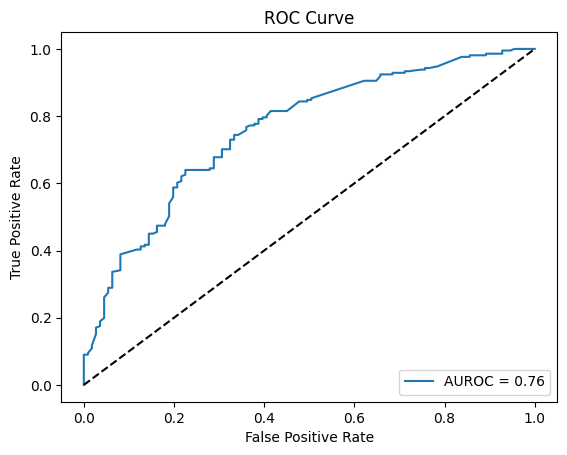

In [19]:
def train_and_predict_lda(X, y, n_components=3, learning_decay=0.5, random_state=16):
    # split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # create a CountVectorizer to vectorize the text data
    vectorizer = CountVectorizer()
    
    # vectorize the text data in the clean_text column of X_train
    X_train_vectorized = vectorizer.fit_transform(X_train['clean_text'])
    
    # create and fit the LDA model
    lda = LatentDirichletAllocation(n_components=n_components, learning_decay=learning_decay, random_state=random_state)
    lda.fit(X_train_vectorized)
    
    # predict the topic probabilities for the training data
    train_topic_probs = lda.transform(X_train_vectorized)
    
    # add the topic probabilities as columns to the X DataFrame for the training rows
    for i in range(n_components):
        X.loc[X_train.index, f'topic_{i}'] = train_topic_probs[:, i]
    
    # vectorize the text data in the clean_text column of X_test
    X_test_vectorized = vectorizer.transform(X_test['clean_text'])
    
    # predict the topic probabilities for the test data
    test_topic_probs = lda.transform(X_test_vectorized)
    
    # add the topic probabilities as columns to the X DataFrame for the test rows
    for i in range(n_components):
        X.loc[X_test.index, f'topic_{i}'] = test_topic_probs[:, i]
    
    # add the dominant topic column to the X DataFrame for the training rows
    X_train['dominant_topic'] = np.argmax(train_topic_probs, axis=1)

    # add the dominant topic column to the X DataFrame for the testing rows
    X_test['dominant_topic'] = np.argmax(test_topic_probs, axis=1)

    # combine the training and testing DataFrames back into one
    X = pd.concat([X_train, X_test])

    # create a DataFrame to store the topic statistics
    topic_stats = pd.DataFrame(columns=['topic_id', 'train_count', 'train_mean', 'test_count', 'test_mean'])
    
    # compute the topic statistics for the training and testing sets
    for i in range(n_components):
        train_mask = (X['dominant_topic'] == i)
        test_mask = (X.loc[X_test.index, 'dominant_topic'] == i)
        train_count = train_mask.sum()
        train_mean = y_train[train_mask].mean()
        test_count = test_mask.sum()
        test_mean = y_test[test_mask].mean()
        topic_stats.loc[i] = [i, train_count, train_mean, test_count, test_mean]
    
    return topic_stats



eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida',"Texto"]
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
summary = train_and_predict_lda(X,y, n_components=3, learning_decay=0.5, random_state=16)

X = X.drop(["clean_text"],axis=1)

y_pred_train, y_pred_test, model_score, X_train, X_test, y_train, y_test = xgb_classifier(X,y)

In [10]:
summary

,topic_id,train_count,train_mean,test_count,test_mean
0,0.0,271.0,0.747619,61.0,0.557377
1,1.0,218.0,0.747573,12.0,0.583333
2,2.0,1120.0,0.662457,249.0,0.682731


In [11]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="train")


,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Default,0.50,0.81,0.95,0.81,0.88
1,Precision-Recall trade-off,0.49,0.81,0.97,0.80,0.88
2,Balanced Accuracy,0.63,0.79,0.82,0.87,0.90
3,Cohen's Kappa,0.63,0.79,0.82,0.87,0.90
4,Limit to K,0.62,0.79,0.82,0.87,0.89


In [12]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="test")


,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Default,0.50,0.70,0.95,0.70,0.69
1,Precision-Recall trade-off,0.49,0.70,0.98,0.69,0.69
2,Balanced Accuracy,0.63,0.73,0.80,0.79,0.79
3,Cohen's Kappa,0.63,0.73,0.80,0.79,0.79
4,Limit to K,0.62,0.74,0.82,0.79,0.79


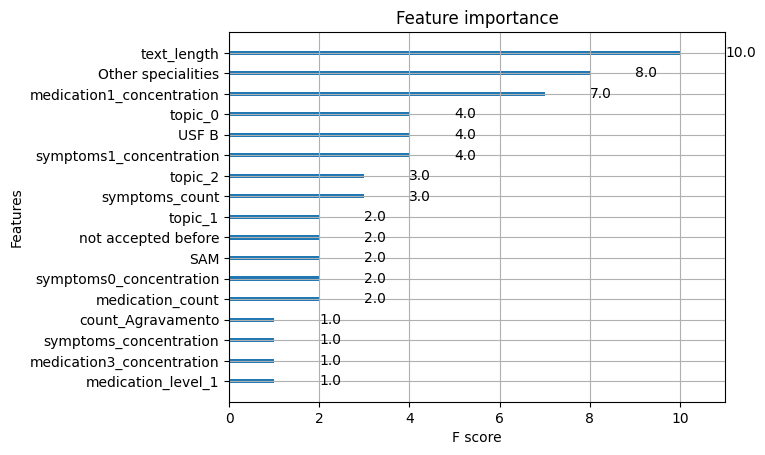

In [13]:
from xgboost import plot_importance

# Plot the feature importance scores
plot_importance(model_score)
plt.show()

# 2 Topics


In [14]:
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [2], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(random_state= 16)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

# get the topic-term distribution from the fitted LDA model
topic_term_dists = best_lda_model.components_ / best_lda_model.components_.sum(axis=1)[:, np.newaxis]

# get the document-topic distribution by transforming the document-term matrix using the fitted LDA model
doc_topic_dists = best_lda_model.transform(data_vectorized)

# get the document lengths (number of words per document) by summing the document-term matrix along the columns axis
doc_lengths = data_vectorized.sum(axis=1).getA1()

# get the vocabulary from the vectorizer object
vocab = vectorizer.get_feature_names_out()

# get the term frequencies by summing the document-term matrix along the rows axis
term_frequency = data_vectorized.sum(axis=0).getA1()

import pyLDAvis

pyLDAvis.enable_notebook()
panel = pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab, term_frequency)
panel

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 2}
Best Log Likelihood Score:  -48275.62529678024
Model Perplexity:  567.4627072749181


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.108186  0.0       1        1  58.870785
0     -0.108186  0.0       2        1  41.129215, topic_info=          Term        Freq       Total Category  logprob  loglift
835        tac  275.000000  275.000000  Default  30.0000  30.0000
143         ce  257.000000  257.000000  Default  29.0000  29.0000
157    clinico  183.000000  183.000000  Default  28.0000  28.0000
740  relatorio  139.000000  139.000000  Default  27.0000  27.0000
887   vascular  117.000000  117.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
708     quadro   78.712176  210.643534   Topic2  -5.2369  -0.0959
277     doente   93.213517  502.615868   Topic2  -5.0678  -0.7965
39       algum   71.648826  140.350449   Topic2  -5.3309   0.2161
625      outro   68.467116  155.013910   Topic2  -5.3763   0.0713
381      fazer   68.967054  288.819056   Topic2  -5.3691  -0.5437

[157 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
7         1  0.027783      acentuação
7         2  0.972421      acentuação
10        1  0.975226  acompanhamento
10        2  0.048761  acompanhamento
17        1  0.891069          actual
...     ...       ...             ...
893       2  0.988434     ventriculos
906       1  0.028555             vit
906       2  0.970871             vit
909       1  0.987381          voltar
909       2  0.036570          voltar

[239 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [17]:
def xgb_classifier(features, target):
    # split X and y into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2,random_state=16,shuffle=False)

    #X_train['before_accepted'] = X_train['before_accepted'].astype('category')
    #X_test['before_accepted'] = X_test['before_accepted'].astype('category')

    # Convert data into DMatrix format
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical = True)
    dtest = xgb.DMatrix(X_test, enable_categorical = True)

    # Set parameters for the XGBoost model
    param = {
        'max_depth': 3,
        'eta': 0.3,
        'objective': 'binary:logistic',
        'seed': 16
    }

    # Train the model
    num_round = 10
    bst = xgb.train(param, dtrain, num_round)

    # Make preictions on the train set
    y_pred_train = bst.predict(dtrain)
    # Make predictions on the test set
    y_pred_test = bst.predict(dtest)

    from sklearn.metrics import roc_curve, auc

    # Calculate the false positive rate and true positive rate for different thresholds
    fpr, tpr, _ = roc_curve(y_test, y_pred_test)

    # Calculate the AUROC
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label='AUROC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return y_pred_train, y_pred_test, bst.get_score(), X_train, X_test, y_train, y_test 

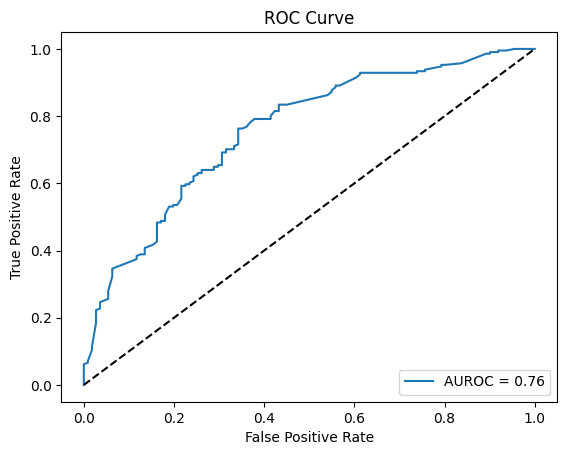

,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Default,0.50,0.80,0.94,0.81,0.89
1,Precision-Recall trade-off,0.55,0.81,0.93,0.82,0.90
2,Balanced Accuracy,0.62,0.80,0.85,0.86,0.90
3,Cohen's Kappa,0.62,0.80,0.85,0.86,0.90
4,Limit to K,0.63,0.79,0.82,0.87,0.89


In [18]:
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida',"Texto"]
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable

summary = train_and_predict_lda(X,y, n_components=2, learning_decay=0.5, random_state=16)
X = X.drop(["clean_text"],axis=1)

y_pred_train, y_pred_test, model_score, X_train, X_test, y_train, y_test = xgb_classifier(X,y)
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="train")


In [ ]:
evaluate_thresholds(y_pred_train,y_train,y_pred_test,y_test,metrics="test")


,Analysis,Threshold,Accuracy,Recall,Precision,Precision@211
0,Default,0.50,0.70,0.93,0.70,0.70
1,Precision-Recall trade-off,0.55,0.71,0.93,0.72,0.71
2,Balanced Accuracy,0.62,0.72,0.86,0.75,0.75
3,Cohen's Kappa,0.62,0.72,0.86,0.75,0.75
4,Limit to K,0.63,0.73,0.82,0.78,0.78


In [ ]:
summary

,topic_id,train_count,train_mean,test_count,test_mean
0,0.0,815.0,0.758678,210.0,0.690476
1,1.0,794.0,0.629032,112.0,0.589286


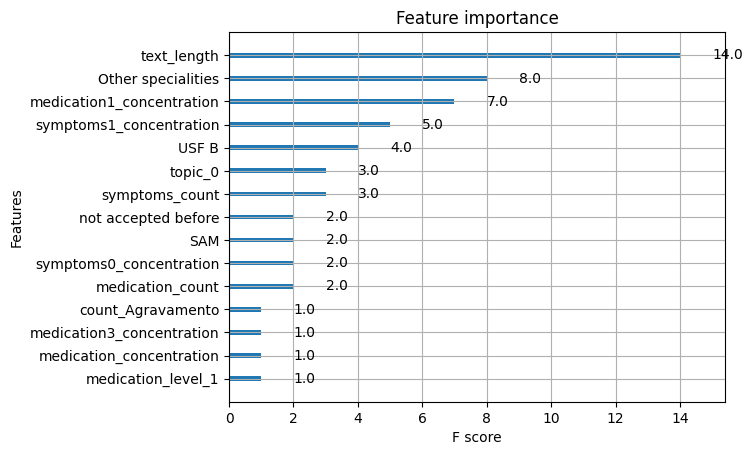

In [ ]:
from xgboost import plot_importance

# Plot the feature importance scores
plot_importance(model_score)
plt.show()